In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from qmmc import *

## Format data

In [3]:
df = pd.read_csv('/Users/rachez/ETSAnonymousPricesFull.csv')

/Users/rachez/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (9,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
idx_buy = df["BuySell"].values == "Buy"
df = df[idx_buy]

idx_done = df["TradeStatus"].values == "Done"
idx_traded_away = df["TradeStatus"].values == "TradedAway"
idx_not_traded = df["TradeStatus"].values == "NotTraded"
df = df[idx_done + idx_traded_away + idx_not_traded]

df["Y"] = (df["BNPPAnsweredQuote"] - df["RFQCompositePrice"]) / np.abs(df["Bid2Mid"])
df = df[df["Y"] < 2]
df = df[df["Y"] > -2]

In [5]:
n = 3
dd = df[df["NbDealers"] == n + 1]

Y_real = dd["Y"].values

I = dd["TradeStatus"].values
II = np.empty(I.shape[0], dtype=int)
II[I == "Done"] = 2
II[I == "TradedAway"] = 1
II[I == "NotTraded"] = 0
I_real = II

In [6]:
m = 5000
n_samples = Y_real.shape[0]
idx = np.random.randint(0, n_samples, 5000)

In [7]:
Y_real = Y_real[idx]
I_real = I_real[idx]

## Estimate model parameters from data

In [8]:
# Priors
mu_0, sigma_0 = Value(0), Value(10)
scale_0, shape_0 = Value(3), Value(3)

# Parameters and variables
mu_V = Normal(mu_0, sigma_0, value=0, name='mu_V')
sigma_V = InvGamma(scale_0, shape_0, value=3, name='sigma_V')
V = Normal(mu_V, sigma_V, size=m, name='V')

Y = Value(Y_real)

mu_W = Normal(mu_0, sigma_0, value=0, name='mu_W')
sigma_W = InvGamma(scale_0, shape_0, value=3, name='sigma_W')
W = Normal(mu_W, sigma_W, size=(m, n), name='W')

@Function
def S(Y=Y, V=V, W=W):
    d = np.empty(Y.shape, dtype=int)
    
    C = np.min(W, axis=1)
    idx_done = Y <= np.minimum(C, V)
    idx_traded_away = C <= np.minimum(Y, V)
    idx_not_traded = V < np.minimum(C, Y)
    
    d[idx_not_traded] = 0
    d[idx_traded_away] = 1
    d[idx_done] = 2
    return d

p = Value(0.0)
I = BernoulliFlip(p, S, k=3, value=I_real, observed=True, name='I')

In [9]:
v_sampler = VSampler(V)
w_sampler = WSampler(W)
pv_sampler = NormalConjugateSampler(mu_V, sigma_V)
pw_sampler = NormalConjugateSampler(mu_W, sigma_W)

In [10]:
model = Model(variables=[mu_V, sigma_V, V, mu_W, sigma_W, W, Y, S, I],
              samplers=[v_sampler, w_sampler, pv_sampler, pw_sampler])

In [11]:
model.samplers

{'V': <qmmc.custom_samplers.VSampler at 0x1312c6f50>,
 'W': <qmmc.custom_samplers.WSampler at 0x1312c6410>,
 'mu_V & sigma_V': <qmmc.samplers.NormalConjugateSampler at 0x1312c6950>,
 'sigma_W & mu_W': <qmmc.samplers.NormalConjugateSampler at 0x1312c6e90>}

In [12]:
# Check that initial state IS NOT consistent.
print sum(I.value != S.value)

2900


In [31]:
%%time
model.estimate(5000)

0% 0% 0% 0% 0% 1% 1% 1% 1% 1% 2% 2% 2% 2% 2% 3% 3% 3% 3% 3% 4% 4% 4% 4% 4% 5% 5% 5% 5% 5% 6% 6% 6% 6% 6% 7% 7% 7% 7% 7% 8% 8% 8% 8% 8% 9% 9% 9% 9% 9% 10% 10% 10% 10% 10% 11% 11% 11% 11% 11% 12% 12% 12% 12% 12% 13% 13% 13% 13% 13% 14% 14% 14% 14% 14% 15% 15% 15% 15% 15% 16% 16% 16% 16% 16% 17% 17% 17% 17% 17% 18% 18% 18% 18% 18% 19% 19% 19% 19% 19% 20% 20% 20% 20% 20% 21% 21% 21% 21% 21% 22% 22% 22% 22% 22% 23% 23% 23% 23% 23% 24% 24% 24% 24% 24% 25% 25% 25% 25% 25% 26% 26% 26% 26% 26% 27% 27% 27% 27% 27% 28% 28% 28% 28% 28% 28% 29% 29% 29% 29% 30% 30% 30% 30% 30% 31% 31% 31% 31% 31% 32% 32% 32% 32% 32% 33% 33% 33% 33% 33% 34% 34% 34% 34% 34% 35% 35% 35% 35% 35% 36% 36% 36% 36% 36% 37% 37% 37% 37% 37% 38% 38% 38% 38% 38% 39% 39% 39% 39% 39% 40% 40% 40% 40% 40% 41% 41% 41% 41% 41% 42% 42% 42% 42% 42% 43% 43% 43% 43% 43% 44% 44% 44% 44% 44% 45% 45% 45% 45% 45% 46% 46% 46% 46% 46% 47% 47% 47% 47% 47% 48% 48% 48% 48% 48% 49% 49% 49% 49% 49% 50% 50% 50% 50% 50% 51% 51% 51% 51% 51% 52% 52% 52

In [32]:
# Check that final state IS consistent
print sum(I.value != S.value)

0


In [33]:
model.samplers

{'V': <qmmc.custom_samplers.VSampler at 0x1312c6f50>,
 'W': <qmmc.custom_samplers.WSampler at 0x1312c6410>,
 'mu_V & sigma_V': <qmmc.samplers.NormalConjugateSampler at 0x1312c6950>,
 'sigma_W & mu_W': <qmmc.samplers.NormalConjugateSampler at 0x1312c6e90>}

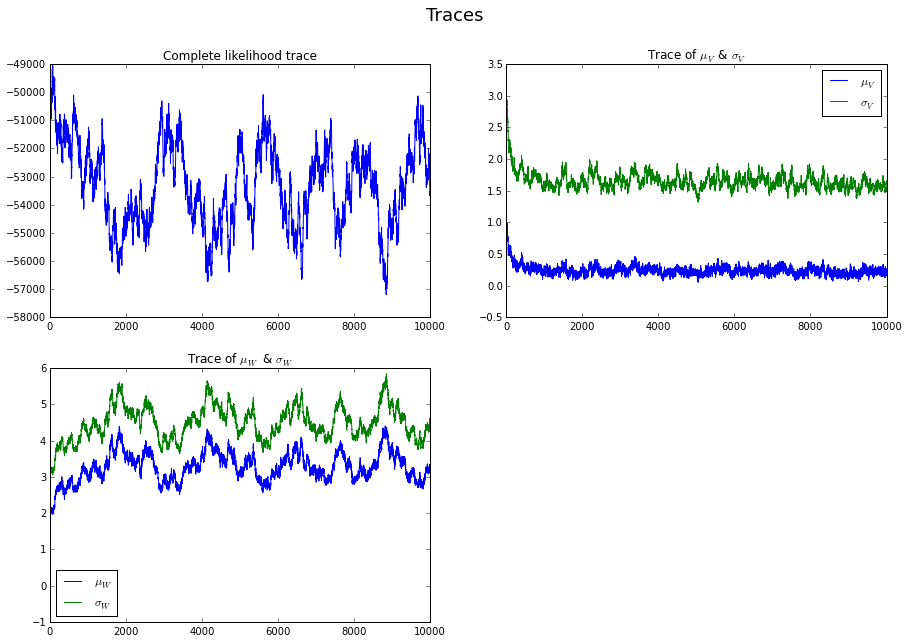

In [34]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(model.logp_hist)
plt.title("Complete likelihood trace")

plt.subplot(2, 2, 2)
mu_V_trace = pv_sampler.history['mu']
sigma_V_trace = pv_sampler.history['sigma']
plt.plot(mu_V_trace)
plt.plot(sigma_V_trace)
plt.legend([r"$\mu_V$", r"$\sigma_V$"], loc='best')
plt.title(r"Trace of $\mu_V$ & $\sigma_V$")

plt.subplot(2, 2, 3)
mu_W_trace = pw_sampler.history['mu']
sigma_W_trace = pw_sampler.history['sigma']
plt.plot(mu_W_trace)
plt.plot(sigma_W_trace)
plt.legend([r"$\mu_W$", r"$\sigma_W$"], loc='best')
plt.title(r"Trace of $\mu_W$ & $\sigma_W$")

plt.suptitle(r"Traces", size=18)
plt.show()

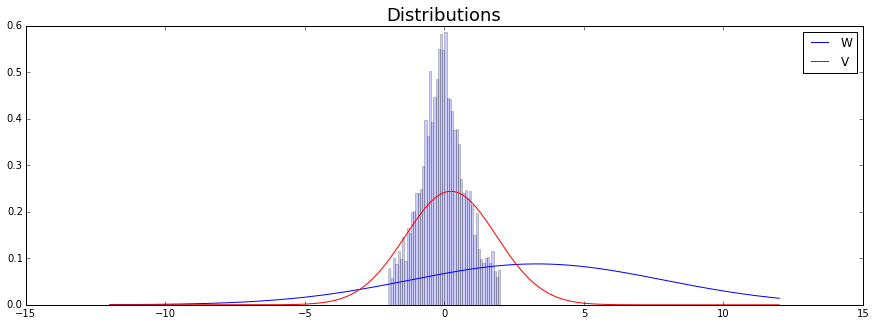

In [35]:
from scipy.stats import norm

plt.figure(figsize=(15, 5))

n_burn = 2000
mu_V_avg = np.mean(mu_V_trace[n_burn:])
sigma_V_avg = np.mean(sigma_V_trace[n_burn:])
mu_W_avg = np.mean(mu_W_trace[n_burn:])
sigma_W_avg = np.mean(sigma_W_trace[n_burn:])

xx = np.linspace(-12, 12, 1000)

plt.plot(xx, norm.pdf(xx, mu_W_avg, sigma_W_avg), color='b')
plt.plot(xx, norm.pdf(xx, mu_V_avg, sigma_V_avg), color='r')
plt.hist(df["Y"].values[idx], bins=50, normed=True, alpha=0.2)

plt.legend(['W', 'V'])
plt.title(r"Distributions", size=18)
plt.show() 